In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp2d, interp1d
import matplotlib.pyplot as plt
from copy import copy
import pyMelt
from pyMelt import phaseDiagramTools

In [2]:
klb1 = pd.read_csv('klb1_grid.csv')
klb1.head()

,pressure,temperature,cpx,cpx_Al2O3,cpx_CaO,cpx_Cr2O3,cpx_FeO,cpx_K2O,cpx_MgO,cpx_Na2O,...,g_SiO2,g_TiO2,g_xAlM2,g_xCaM1,g_xCrM2,g_xFe3M2,g_xFeM1,g_xMgM1,g_xMgM2,g_xTiM2
0,4.5,1100,0.07593,1.558002,19.262284,0.280877,3.015965,0.105515,24.837718,0.751036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.5,1110,0.07583,1.581440,19.147837,0.281956,3.033520,0.104870,24.941340,0.743301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.5,1120,0.07572,1.604967,19.028983,0.282958,3.051522,0.104225,25.048587,0.735717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.5,1130,0.07562,1.628634,18.905513,0.283885,3.069948,0.103580,25.159665,0.728235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.5,1140,0.07552,1.652414,18.777163,0.284736,3.088870,0.102935,25.274794,0.720929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To do:
- Integrate functions into the pyMelt module
- Create a jupyter workflow for importing thermocalc 
- Create a jupyter workflow for producing MELTS phase diagrams
- Re-run thermocalc over a finer grid (and extended pressure range)

In [10]:
class gridsThermocalc(object):
    """
    Methods for processing thermocalc input.
    """
    def __init__(self, 
                 df, 
                 phases=['ol', 'cpx', 'opx', 'g', 'spn', 'liq', 'pl'], 
                 oxides={'SiO2':  28.085 + 15.999 * 2,
                         'MgO':   24.305 + 15.999,
                         'FeO':   55.845 + 15.999,
                         'CaO':   40.078 + 15.999,
                         'Al2O3': 2 * 26.982 + 15.999 * 3,
                         'Na2O':  22.99 * 2 + 15.999,
                         'K2O':   39.098 * 2 + 15.999,
                         'MnO':   54.938 + 15.999,
                         'TiO2':  79.867,
                         'P2O5':  2 * 30.974 + 5 * 15.999,
                         'Cr2O3': 151.992,
                         'NiO':   58.693 + 16,
                         'CoO':   44.01,
                         'Fe2O3': 55.845 * 2 + 15.999 * 3,
                         'H2O':   18.02,
                         'CO2':   44.01,
                         'O': 15.999}):
    
        self.df = df.copy()
        self.phases  = phases
        self.oxides = oxides
        
        self.calculate_mass_fractions()
        self.calculate_liquid_wtpt()
        
        # Thermocalc uses kbar as the pressure unit. pyMelt uses GPa, convert:
        self.df['pressure'] = self.df['pressure'] / 10
        
    def calculate_mass_fractions(self):
        """
        """

        # TC calculates modes on a 1-atom basis.

        # First, calculate un-normalised mass fractions
        phases_found = []
        for ph in self.phases:
            if ph in self.df.columns:
                phases_found.append(ph)
                mass = np.zeros([np.shape(self.df)[0]])
                for ox in self.oxides.keys():
                    if ph + '_' + ox in self.df.columns:
                        mass += self.df[ph + '_' + ox] * self.oxides[ox]
                self.df[ph+'_mass'] = mass * self.df[ph]

        # Calculate the normalising value:
        for ph in phases_found:
            if ph is phases_found[0]:
                self.df['total_mass'] = self.df[ph+'_mass'].fillna(0.0)
            else:
                self.df['total_mass'] = self.df['total_mass'] + self.df[ph+'_mass'].fillna(0.0)

        # Normalise:
        for ph in phases_found:
            self.df[ph+'_mass'] = self.df[ph+'_mass']/self.df['total_mass']
        self.df['total_mass'] = self.df['total_mass']/self.df['total_mass']
    
    def calculate_liquid_wtpt(self):
        """
        Method for converting mole fraction oxides to wtpt oxides.
        """
        
        # First, convert FeO + O into FeO + Fe2O3:
        self.df['liq_Fe2O3'] = self.df['liq_O']
        self.df['liq_FeO'] = self.df['liq_FeO'] - 2*self.df['liq_O']
        self.df.drop('liq_O', axis=1, inplace=True)
        
        self.df['liq_total_mass'] = np.zeros(self.df.shape[0])
        for ox in self.oxides:
            if 'liq_' + ox in self.df.columns:
                self.df['liq_' + ox + '_wtpt'] = self.df['liq_' + ox] * self.oxides[ox]
                self.df['liq_total_mass'] += self.df['liq_' + ox] * self.oxides[ox]
        
        for ox in self.oxides:
            if 'liq_' + ox in self.df.columns:
                self.df['liq_' + ox + '_wtpt'] = self.df['liq_' + ox + '_wtpt'] / self.df['liq_total_mass'] * 100
    
    def make_f_grid(self, variable, deltaf=0.01, fill_value=0.0):
        f = np.arange(0.0, 1.0, deltaf)
        p = self.df['pressure'].unique()
        pp, ff = np.meshgrid(p, f)
        grid = np.zeros([3, np.shape(pp)[0], np.shape(pp)[1]])
        grid[0, :, :] = pp
        grid[1, :, :] = ff

        for i in range(np.shape(pp)[1]):
            dfp = self.df[(self.df.pressure==pp[0, i])]
            x = dfp.liq_mass.copy()
            y = dfp[variable].copy()

            # To ensure smoothness to zero, we will artificially overshoot F=0:
            first_finite_ind = x[(np.isnan(x) == False)].index[0]
            dfdi0 = x.loc[first_finite_ind + 1] - x.loc[first_finite_ind]
            x.loc[first_finite_ind - 1] = x.loc[first_finite_ind] - dfdi0

            # Now ensure that the variable can overshoot on both ends:
            y = y[(np.isnan(x) == False)]

            if len(y[(np.isnan(y) == False)]) > 1:
                # Check lower end:
                if np.isnan(y.iloc[0]):
                    first_finite_ind = y[(np.isnan(y) == False)].index[0]
                    dydx = (y.loc[first_finite_ind + 1] - y.loc[first_finite_ind])/(x.loc[first_finite_ind + 1] - x.loc[first_finite_ind])
                    y.loc[first_finite_ind - 1] = y.loc[first_finite_ind] + dydx*(x.loc[first_finite_ind - 1] - x.loc[first_finite_ind])

                # Check upper end:
                if np.isnan(y.iloc[len(y)-1]):
                    last_finite_ind = y[(np.isnan(y) == False)].index[-1]
                    dydx = (y.loc[last_finite_ind] - y.loc[last_finite_ind - 1])/(x.loc[last_finite_ind] - x.loc[last_finite_ind - 1])
                    y.loc[last_finite_ind + 1] = y.loc[last_finite_ind] + dydx*(x.loc[last_finite_ind + 1] - x.loc[last_finite_ind])

                x = x[(np.isnan(x) == False) & (np.isnan(y) == False)]

                if len(x) > 1:
                    y = y[(np.isnan(x) == False) & (np.isnan(y) == False)]

                    try:
                        pinterp = interp1d(x, y, fill_value=fill_value, bounds_error=False, kind='quintic')
                    except:
                        try:
                            pinterp = interp1d(x, y, fill_value=fill_value, bounds_error=False, kind='cubic')
                        except:
                            pinterp = interp1d(x, y, fill_value=fill_value, bounds_error=False)

                    grid[2, :, i] = pinterp(f)

        return grid       

In [5]:
class interpolate_grid(object):
    def __init__(self, grid, keep_positive=True):
        self.interp = interp2d(grid[0,0], grid[1,:,0], grid[2], kind='cubic')
        self.keep_positive = keep_positive
    
    def __call__(self, x, y):
        value = self.interp(x, y)
        if self.keep_positive and value < 0:
            value = np.array([0.0])
        return value

In [376]:
def check_interpolation(f, x=np.linspace(5, 70, 200), y=np.linspace(0, 1, 200)):
    xx, yy = np.meshgrid(x, y)
    cc = np.zeros([3, np.shape(xx)[0], np.shape(xx)[1]])
    cc[0] = xx
    cc[1] = yy

    for i in range(np.shape(xx)[0]):
        for j in range(np.shape(xx)[1]):
            cc[2, i, j] = f(xx[i,j], yy[i,j])
            if cc[2, i, j] < 0:
                cc[2, i, j] = 0
    
    return cc

In [414]:
def check_mass_conservation(f_list, x=np.linspace(5, 70, 200), y=np.linspace(0, 1, 200)):
    xx, yy = np.meshgrid(x, y)
    cc = np.zeros([3, np.shape(xx)[0], np.shape(xx)[1]])
    cc[0] = xx
    cc[1] = yy

    for i in range(np.shape(xx)[0]):
        for j in range(np.shape(xx)[1]):
            for f in f_list:
                cc[2, i, j] += f(xx[i,j], yy[i,j])
            cc[2, i, j] += yy[i,j]
    
    return cc

In [6]:
class phaseDiagram(object):
    """
    Reads in a phase diagram grid and sets up the spline interpolation functions.
    """
    def __init__(self, grids, variables=None):
        self._interpolated_functions = {}
        if variables is None:
            self.variables = grids.df.columns
        else:
            self.variables = variables
        
        for col in self.variables:
            if col not in ['pressure', 'temperature', 'X', 'liq', 'liq_mass']:
                grid = grids.make_f_grid(col)
                self._interpolated_functions[col] = interpolate_grid(grid)
    
    def __call__(self, variable, P, F):
        return self._interpolated_functions[variable](P, F)[0]

In [497]:
class phaseDiagramTraceSpecies(pyMelt.chemistry.species):
    """
    Calculates trace element partitioning based on a phase diagram. Needs more info.
    """
    def __init__(self, name, c0, phaseDiagram,
                 olv_D, cpx_D, opx_D, spn_D, grt_D, plg_D, 
                 porosity=0.0, **kwargs):
        self.calculation_type = "instantaneous"
        self.name = name
        self.c0 = c0
        self.phaseDiagram = phaseDiagram
        self._D = {"ol": olv_D,
                   "cpx": cpx_D,
                   "opx": opx_D,
                   "spn": spn_D,
                   "g": grt_D,
                   "pl": plg_D}
        self.porosity = porosity
        self._cs = c0
        self._F_prev = 0.0
        self._cl_prev = None

        
    def composition(self, state):
        # Check if this is a new calculation or not:
        if state.F < self._F_prev:
            self._cs = self.c0

        if state.F == 1:
            # If the lithology is immediately fully molten:
            if self_cl_prev is None:
                return self._cs
            else:
                return self._cl_prev

        D = self.D_bulk(state)

        if D < 1e-4:
            _warn(
                self.name
                + " is extremely incompatible, unless the step size is extremely small"
                " its partitioning behaviour is unlikely to be captured correctly. "
                "You are probably better off calculating it using the "
                "ContinuousSpecies_accumulated class."
            )

        k1 = self._dcsdX(self._F_prev, self._cs,
                         self._cl(self._cs, D))
        k2 = self._dcsdX(
            self._F_prev + (state.F - self._F_prev) / 2,
            self._cs + k1 * (state.F - self._F_prev) / 2,
            self._cl(self._cs + k1 * (state.F - self._F_prev) / 2,
                     D),
        )
        k3 = self._dcsdX(
            self._F_prev + (state.F - self._F_prev) / 2,
            self._cs + k2 * (state.F - self._F_prev) / 2,
            self._cl(self._cs + k2 * (state.F - self._F_prev) / 2,
                     D),
        )
        k4 = self._dcsdX(
            self._F_prev + (state.F - self._F_prev),
            self._cs + k3 * (state.F - self._F_prev),
            self._cl(self._cs + k3 * (state.F - self._F_prev),
                     D),
        )
        cs = self._cs + (1 / 6) * (state.F - self._F_prev) * (k1 + 2 * k2 + 2 * k3 + k4)
        cl = self._cl(cs, D)

        # Check if discretisation is too course
        if (k1 + 2 * k2 + 2 * k3 + k4) > 0 and D < 1:
            _warn(
                "Discretisation is too course to capture the behaviour of "
                + self.name
                + "."
            )
            cl = _np.nan
            self._cs = _np.nan

        # Prevent float errors
        elif cs < 1e-6:
            self._cs = 0
        else:
            self._cs = cs

        self._F_prev = state.F
        self._cl_prev = cl

        return cl
    
    def D(self, state):
        """
        The partition coefficient. If a constant partition coefficient is used it will return that
        value. If a variable coefficient is used it will call the function to calculate it.

        Parameters
        ----------
        state : pandas.Series
            The state of the system, e.g. temperature (T), pressure (P), melt fraction (F). This
            will most likely be generated automatically by the `MeltingColumn_1D` class.

        Returns
        -------
        float
            The partition coefficient
        """
        d = {}

        for min in self._D:
            if callable(self._D[min]):
                d[min] = self._D[min](state)
            else:
                d[min] = self._D[min]

        return d
    
    def D_bulk(self, state):
        """
        """
        Dminerals = self.D(state)
        mineralProportions = self.mineralProportions(state)
        
        D = sum([Dminerals[mineral] * mineralProportions[mineral]
                 for mineral in Dminerals.keys()])
        
        D = (1 - self.porosity) * D + self.porosity
        
        return D
    
    def mineralProportions(self, state):
        props = {}
        for mineral in self._D.keys():
            props[mineral] = self.phaseDiagram(mineral + '_mass', state['P'], state['F'])
        return props
    
    def _dcsdX(self, X, cs, cl):
        """
        Rate of change of rare-earth element concentration in point average solid. This
        expression is only strictly valid in the limit dX->0.

        Parameters
        ----------
        X : float
            melt fraction
        cs : float
            point average solid residue composition
        cl : float
            liquid composition
        Dbar : float
            bulk distribution coefficient for solid assemblage
        Pbar : float
            bulk distribution coefficient for melting package

        Returns
        -------
        float
            rate of change of REE concentration in point average solid residue with respect to
            melt fraction

        """
        dcsdX = (cs - cl) / (1 - X)

        return dcsdX
    
    def _cl(self, cs, Dbar):
        """
        Calculates instantaneous melt composition generated from a point average solid.

        Parameters
        ----------
        cs : float
            point average solid residue composition
        Dbar : float
            bulk distribution coefficient for solid assemblage


        Returns
        -------
        float
            instantaneous melt composition

        """
        cl = cs / Dbar
        return cl

In [543]:
class phaseDiagramMajorSpecies(pyMelt.chemistry.species):
    """
    Calculates trace element partitioning based on a phase diagram. Needs more info.
    """
    def __init__(self, name, phaseDiagram, prefix='liq_', suffix='_wtpt',
                 **kwargs):
        self.calculation_type = "instantaneous"
        self.name = name
        self.phaseDiagram = phaseDiagram
        self.prefix = prefix
        self.suffix = suffix
        self._F_prev = 0.0
    
    def composition(self, state):
        return self.phaseDiagram(self.prefix + self.name + self.suffix , state['P'], state['F'])

In [11]:
klb1_grid = gridsThermocalc(klb1)

In [13]:
phased = phaseDiagram(klb1_grid, ['ol_mass', 'g_mass', 'cpx_mass', 'opx_mass', 'spn_mass', 'pl_mass', 'liq_MgO_wtpt', 'liq_FeO_wtpt', 'liq_Fe2O3_wtpt'])

In [16]:
phased('liq_FeO_wtpt', 0.5, 0.5)

9.718215639079723

In [549]:
lz = pyMelt.lithologies.matthews.klb1()
mantle = pyMelt.mantle([lz], [1.0], ['lz'])
col = mantle.adiabaticMelt(1480.0, Pend=0.5)

In [550]:
La = phaseDiagramTraceSpecies('La', pyMelt.chemistry.workman05_dmm['La'], phased,
                              olv_D=pyMelt.chemistry.olv_D['La'], 
                              cpx_D=pyMelt.chemistry.cpx_D['La'], 
                              opx_D=pyMelt.chemistry.opx_D['La'], 
                              spn_D=pyMelt.chemistry.spn_D['La'], 
                              grt_D=pyMelt.chemistry.grt_D['La'], 
                              plg_D=pyMelt.chemistry.plg_D['La'],
                              porosity=0.005)

Yb = phaseDiagramTraceSpecies('Yb', pyMelt.chemistry.workman05_dmm['Yb'], phased,
                              olv_D=pyMelt.chemistry.olv_D['Yb'], 
                              cpx_D=pyMelt.chemistry.cpx_D['Yb'], 
                              opx_D=pyMelt.chemistry.opx_D['Yb'], 
                              spn_D=pyMelt.chemistry.spn_D['Yb'], 
                              grt_D=pyMelt.chemistry.grt_D['Yb'], 
                              plg_D=pyMelt.chemistry.plg_D['Yb'],
                              porosity=0.005)

MgO = phaseDiagramMajorSpecies('MgO', phased)

col.calculateChemistry(species_objects={'lz': [La, Yb, MgO]})
                       

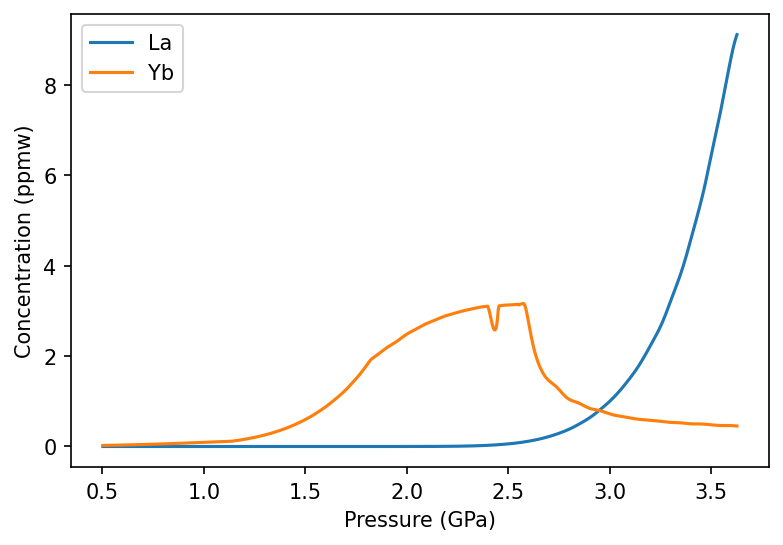

In [551]:
f, a = plt.subplots(dpi=150)
a.plot(col.P, col.lithologies['lz']['La'], label='La')
a.plot(col.P, col.lithologies['lz']['Yb'], label='Yb')
a.set_xlabel('Pressure (GPa)')
a.set_ylabel('Concentration (ppmw)')
a.legend()
plt.show()

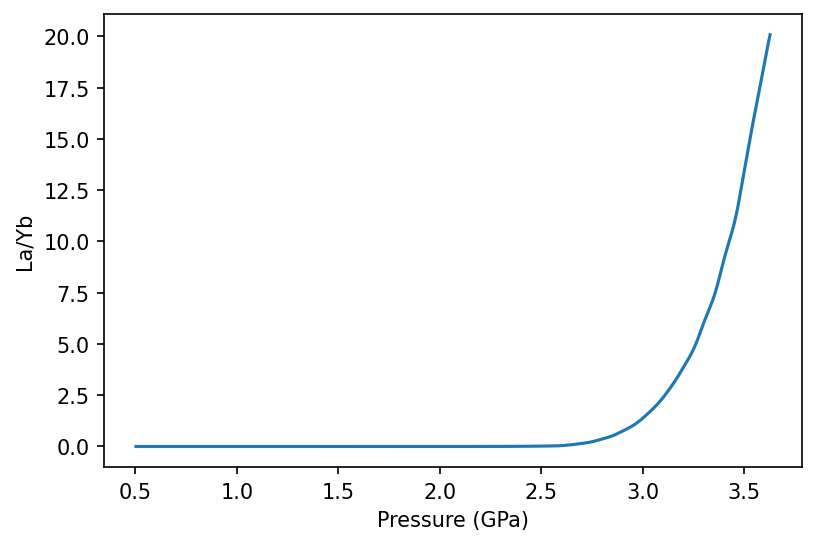

In [552]:
f, a = plt.subplots(dpi=150)
a.plot(col.P, col.lithologies['lz']['La']/col.lithologies['lz']['Yb'])
a.set_xlabel('Pressure (GPa)')
a.set_ylabel('La/Yb')
plt.show()

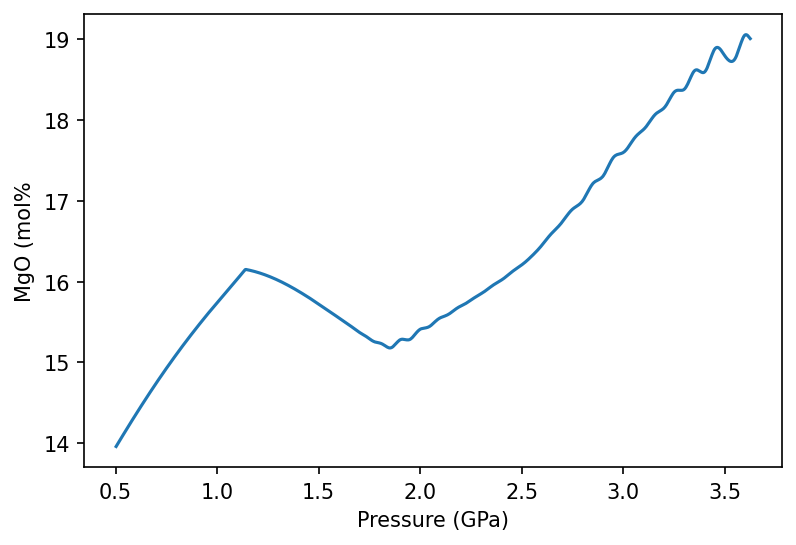

In [553]:
f, a = plt.subplots(dpi=150)
a.plot(col.P, col.lithologies['lz']['MgO'])
a.set_xlabel('Pressure (GPa)')
a.set_ylabel('MgO (mol%')
plt.show()

In [406]:
calculate_mass_fractions(klb1)

In [419]:
g = make_f_grid(klb1, 'g_mass')
g = interpolate_grid(g)
cpx = make_f_grid(klb1, 'cpx_mass')
cpx = interpolate_grid(cpx)
opx = make_f_grid(klb1, 'opx_mass')
opx = interpolate_grid(opx)
ol = make_f_grid(klb1, 'ol_mass')
ol = interpolate_grid(ol)
spn = make_f_grid(klb1, 'spn_mass')
spn = interpolate_grid(spn)
pl = make_f_grid(klb1, 'pl_mass')
pl = interpolate_grid(pl)
cpx_xAlT = make_f_grid(klb1, 'cpx_xAlT')
cpx_xAlT = interpolate_grid(cpx_xAlT)

In [489]:
phased = phaseDiagram(klb1)

In [474]:
phased('cpx_mass', 5.0, 0.4)

TypeError: 'float' object is not subscriptable

In [487]:
phased._interpolated_functions['cpx_mass'](5.0, 0.4)

0.0

In [480]:
col.P

0      3.630495
1      3.626495
2      3.622495
3      3.618495
4      3.614495
         ...   
778    0.518495
779    0.514495
780    0.510495
781    0.506495
782    0.502495
Name: P, Length: 783, dtype: float64

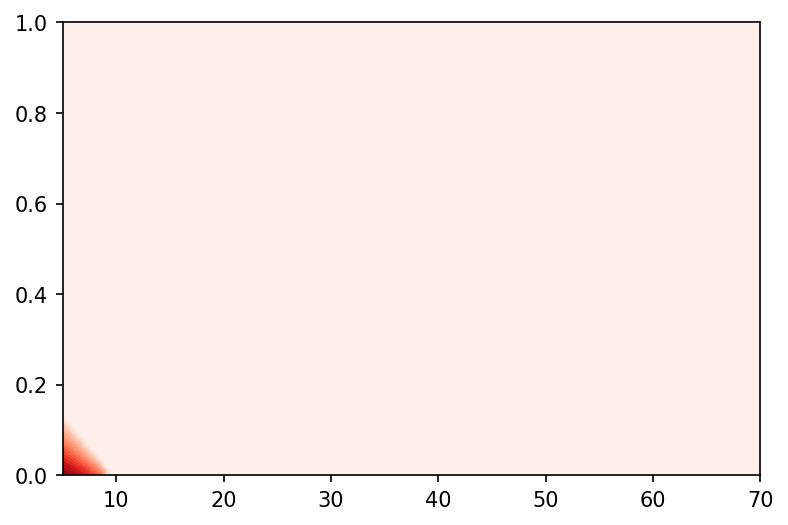

In [421]:
cc = check_interpolation(pl)
f, a = plt.subplots(dpi=150)
# a.contourf(cc[0], cc[1], cc[2]/(1-cc[1]), levels=20, cmap=plt.cm.Reds)
a.contourf(cc[0], cc[1], cc[2], levels=20, cmap=plt.cm.Reds)

plt.show()

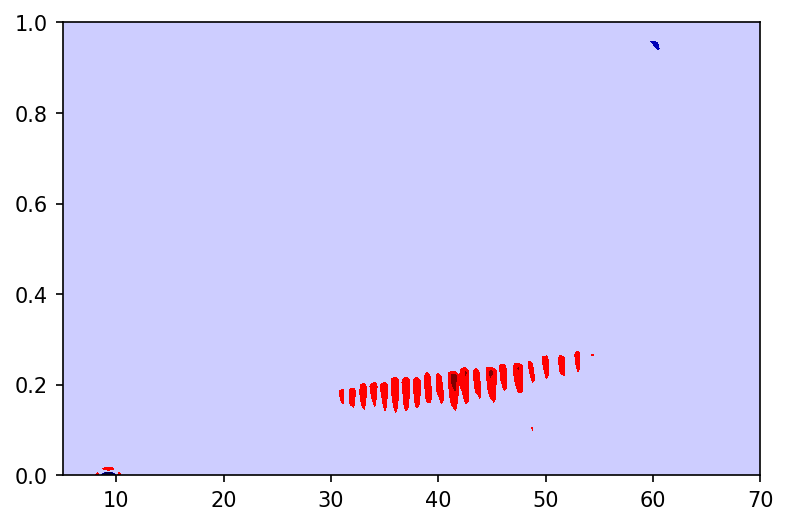

In [422]:
cc = check_mass_conservation([g, cpx, opx, ol, spn, pl])
f, a = plt.subplots(dpi=150)
a.contourf(cc[0], cc[1], cc[2], levels=20, cmap=plt.cm.seismic, vmin=0.9, vmax=1.1)

plt.show()

In [405]:
def calculate_mass_fractions(df, phases=['ol', 'cpx', 'opx', 'g', 'spn', 'liq', 'pl'], 
                             oxides={'SiO2':  28.085 + 15.999 * 2,
                                     'MgO':   24.305 + 15.999,
                                     'FeO':   55.845 + 15.999,
                                     'CaO':   40.078 + 15.999,
                                     'Al2O3': 2 * 26.982 + 15.999 * 3,
                                     'Na2O':  22.99 * 2 + 15.999,
                                     'K2O':   39.098 * 2 + 15.999,
                                     'MnO':   54.938 + 15.999,
                                     'TiO2':  79.867,
                                     'P2O5':  2 * 30.974 + 5 * 15.999,
                                     'Cr2O3': 151.992,
                                     'NiO':   58.693 + 16,
                                     'CoO':   44.01,
                                     'Fe2O3': 55.845 * 2 + 15.999 * 3,
                                     'H2O':   18.02,
                                     'CO2':   44.01,
                                     'O': 15.999}):
    
    # TC calculates modes on a 1-atom basis.
    
    # First, calculate un-normalised mass fractions
    phases_found = []
    for ph in phases:
        if ph in df.columns:
            phases_found.append(ph)
            mass = np.zeros([np.shape(df)[0]])
            for ox in oxides.keys():
                if ph + '_' + ox in df.columns:
                    mass += df[ph + '_' + ox] * oxides[ox]
            df[ph+'_mass'] = mass * df[ph]
    
    # Calculate the normalising value:
    for ph in phases_found:
        if ph is phases_found[0]:
            df['total_mass'] = df[ph+'_mass'].fillna(0.0)
        else:
            df['total_mass'] = df['total_mass'] + df[ph+'_mass'].fillna(0.0)
    
    # Normalise:
    for ph in phases_found:
        df[ph+'_mass'] = df[ph+'_mass']/df['total_mass']
    df['total_mass'] = df['total_mass']/df['total_mass']

In [ ]:
def calculate_liquid_wtpt(df, prefix='liq_',
                          oxides={'SiO2':  28.085 + 15.999 * 2,
                                  'MgO':   24.305 + 15.999,
                                  'FeO':   55.845 + 15.999,
                                  'CaO':   40.078 + 15.999,
                                  'Al2O3': 2 * 26.982 + 15.999 * 3,
                                  'Na2O':  22.99 * 2 + 15.999,
                                  'K2O':   39.098 * 2 + 15.999,
                                  'MnO':   54.938 + 15.999,
                                  'TiO2':  79.867,
                                  'P2O5':  2 * 30.974 + 5 * 15.999,
                                  'Cr2O3': 151.992,
                                  'NiO':   58.693 + 16,
                                  'CoO':   44.01,
                                  'Fe2O3': 55.845 * 2 + 15.999 * 3,
                                  'H2O':   18.02,
                                  'CO2':   44.01,
                                  'O': 15.999}):

In [20]:
def make_grid(df, variable):
    p = df['pressure'].unique()
    t = df['temperature'].unique()
    pp, tt = np.meshgrid(p, t)
    grid = np.zeros([3, np.shape(tt)[0], np.shape(tt)[1]])
    grid[0, :, :] = pp
    grid[1, :, :] = tt
    
    for i in range(np.shape(tt)[0]):
        for j in range(np.shape(tt)[1]):
            try:
                row = df[(df.temperature==tt[i,j]) & (df.pressure==pp[i,j])].iloc[0]
                grid[2, i, j] = row[variable]
            except:
                grid[2, i, j] = np.nan
    
    return grid

In [392]:
def make_f_grid(df, variable, deltaf=0.01, fill_value=0.0):
    f = np.arange(0.0, 1.0, deltaf)
    p = df['pressure'].unique()
    pp, ff = np.meshgrid(p, f)
    grid = np.zeros([3, np.shape(pp)[0], np.shape(pp)[1]])
    grid[0, :, :] = pp
    grid[1, :, :] = ff
    
    for i in range(np.shape(pp)[1]):
        dfp = df[(df.pressure==pp[0, i])]
        x = dfp.liq_mass.copy()
        y = dfp[variable].copy()
        
        # To ensure smoothness to zero, we will artificially overshoot F=0:
        first_finite_ind = x[(np.isnan(x) == False)].index[0]
        dfdi0 = x.loc[first_finite_ind + 1] - x.loc[first_finite_ind]
        x.loc[first_finite_ind - 1] = x.loc[first_finite_ind] - dfdi0
        
        # Now ensure that the variable can overshoot on both ends:
        y = y[(np.isnan(x) == False)]
        
        if len(y[(np.isnan(y) == False)]) > 1:
            # Check lower end:
            if np.isnan(y.iloc[0]):
                first_finite_ind = y[(np.isnan(y) == False)].index[0]
                dydx = (y.loc[first_finite_ind + 1] - y.loc[first_finite_ind])/(x.loc[first_finite_ind + 1] - x.loc[first_finite_ind])
                y.loc[first_finite_ind - 1] = y.loc[first_finite_ind] + dydx*(x.loc[first_finite_ind - 1] - x.loc[first_finite_ind])

            # Check upper end:
            if np.isnan(y.iloc[len(y)-1]):
                last_finite_ind = y[(np.isnan(y) == False)].index[-1]
                dydx = (y.loc[last_finite_ind] - y.loc[last_finite_ind - 1])/(x.loc[last_finite_ind] - x.loc[last_finite_ind - 1])
                y.loc[last_finite_ind + 1] = y.loc[last_finite_ind] + dydx*(x.loc[last_finite_ind + 1] - x.loc[last_finite_ind])

            x = x[(np.isnan(x) == False) & (np.isnan(y) == False)]

            if len(x) > 1:
                y = y[(np.isnan(x) == False) & (np.isnan(y) == False)]

                try:
                    pinterp = interp1d(x, y, fill_value=fill_value, bounds_error=False, kind='quintic')
                except:
                    try:
                        pinterp = interp1d(x, y, fill_value=fill_value, bounds_error=False, kind='cubic')
                    except:
                        pinterp = interp1d(x, y, fill_value=fill_value, bounds_error=False)

                grid[2, :, i] = pinterp(f)
    
    return grid            
            
    